<a href="https://colab.research.google.com/github/raka-raprast/google_stock_prediction_tensorflow_keras/blob/main/Google_Stock_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Stock Prediction Using TensorFlow and Keras
by Raka Ramadhani Aulia Prasetyo

dataset https://finance.yahoo.com/

**TensorFlow and Keras**

**TensorFlow**
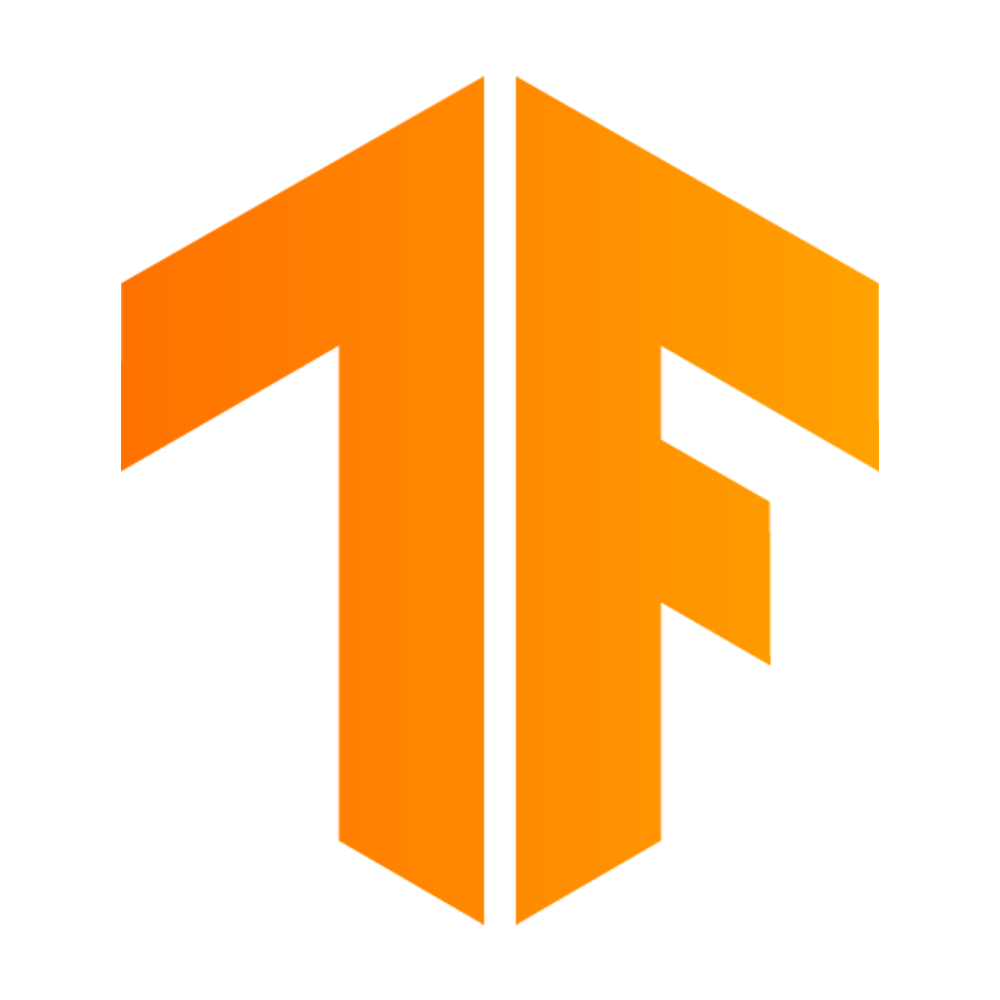

TensorFlow is an end-to-end open source platform for machine learning. It has a comprehensive, flexible ecosystem of tools, libraries and community resources that lets researchers push the state-of-the-art in ML and developers easily build and deploy ML powered applications.
https://www.tensorflow.org/

**Keras**
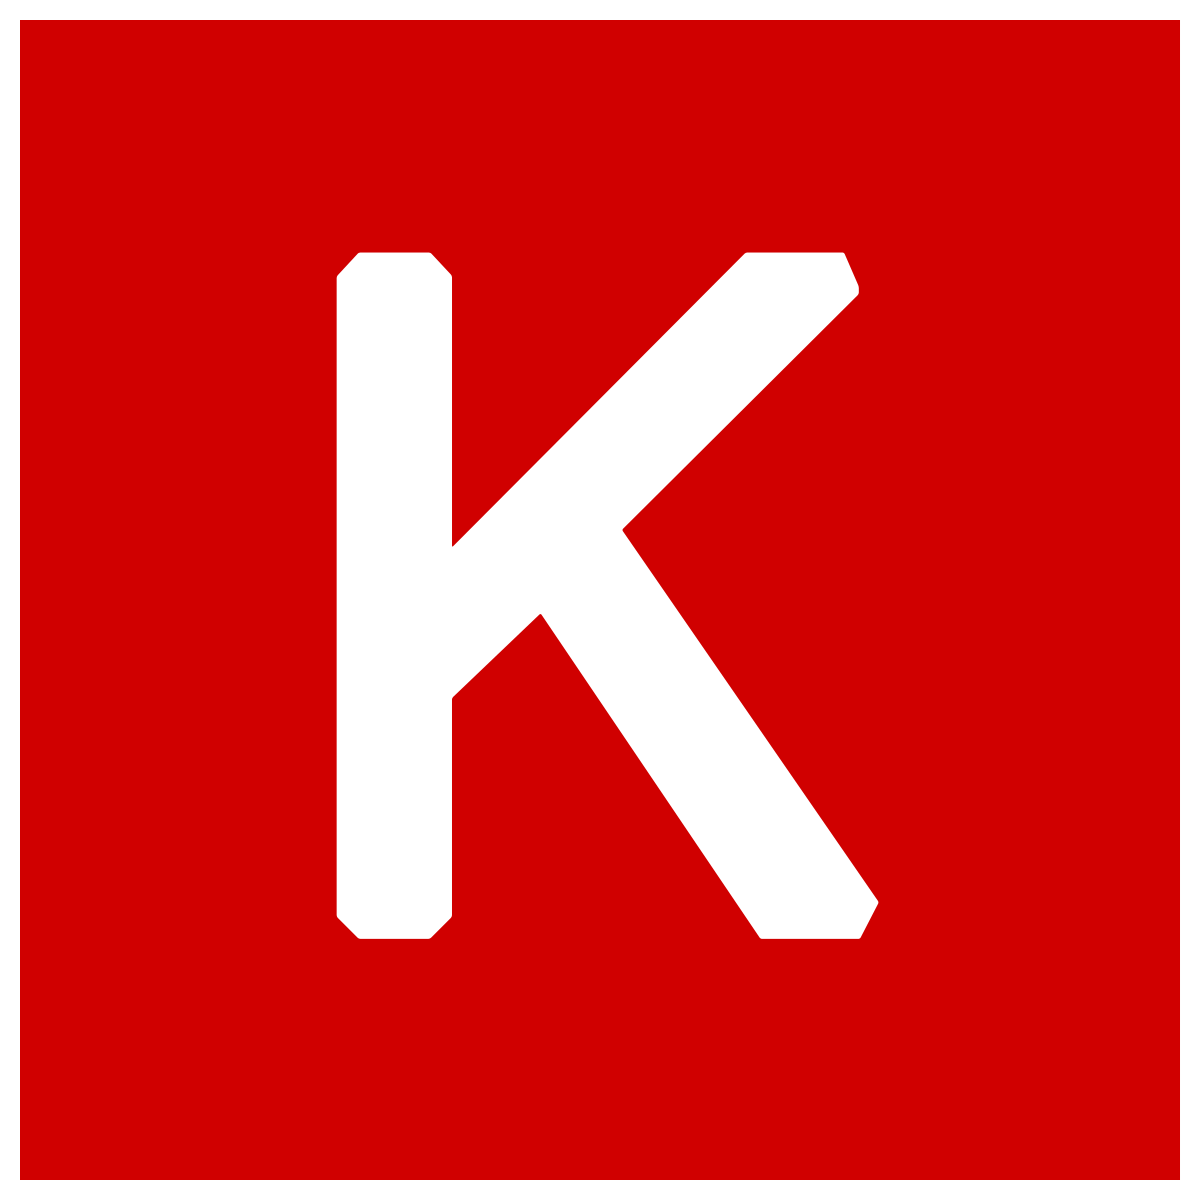

Keras is an API designed for human beings, not machines. Keras follows best practices for reducing cognitive load: it offers consistent & simple APIs, it minimizes the number of user actions required for common use cases, and it provides clear & actionable error messages. It also has extensive documentation and developer guides.
https://keras.io/

## Preparation

In [1]:
!pip install yahoo_fin

     |████████████████████████████████| 81 kB 3.8 MB/s 
     |████████████████████████████████| 83 kB 2.2 MB/s 
     |████████████████████████████████| 103 kB 43.5 MB/s 
     |████████████████████████████████| 127 kB 43.7 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=dbc03eb3b4b3d70708d44845fe4d7e674130288f3e5d18ed38d0fb134ae4824b
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=3eba5afa1f6e5b24f7a623b4fd1a9ab5e760f7b0dde6b3edbb1fcae67ff92a17
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6065 sha256=cd4c5f87506353e6903b7371a8798ef37aea0983cbf75c704b830c354411a9c0
  Stored in directory: /root/.cache/pip/wheels/73/ad/a4/0dff4a6ef231fc0dfa12ffbac2a36ce

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from collections import deque

In [3]:
import os
import numpy as np
import pandas as pd
import random
import time

In [4]:
# set seed for same result after several times of rerunning
np.random.seed(221)
tf.random.set_seed(221)
random.seed(221)

In [5]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

In [6]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, split_by_date=True,
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # check ticker
    if isinstance(ticker, str):
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        df = ticker
    else:
        raise TypeError("ticker can be either a str or a `pd.DataFrame` instances")
    result = {}
    result['df'] = df.copy()
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    # add date as a column
    if "date" not in df.columns:
        df["date"] = df.index
    if scale:
        column_scaler = {}
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
        result["column_scaler"] = column_scaler
    # add the target column (label)
    df['future'] = df['adjclose'].shift(-lookup_step)
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns + ["date"]].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    last_sequence = list([s[:len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    if split_by_date:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"]  = X[train_samples:]
        result["y_test"]  = y[train_samples:]
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, 
                                                                                test_size=test_size, shuffle=shuffle)
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    # retrieve test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    # remove duplicated dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    return result

In [7]:
def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

In [8]:
# Window size or the sequence length
N_STEPS = 50
# Lookup step, 1 is the next day
LOOKUP_STEP = 7

In [9]:
# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"

In [10]:
# whether to shuffle the dataset
SHUFFLE = True
shuffle_str = f"sh-{int(SHUFFLE)}"

In [11]:
# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"

In [12]:
# test ratio size, 0.15 is 15%
TEST_SIZE = 0.15

In [13]:
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]

In [14]:
# date now
date_now = time.strftime("%Y-%m-%d")

### Model Parameter

In [15]:
N_LAYERS = 3

In [16]:
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256

In [17]:
# 50% dropout
DROPOUT = 0.5

In [18]:
# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### Training Parameter

### Mean Absolute Error Loss

In [19]:
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 500

In [20]:
# Amazon stock market
ticker = "GOOG"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")

In [21]:
# model name to save, making it as unique as possible based on parameters
model_goog = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-\
{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
    model_goog += "-b"

In [22]:
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

## Data Visualization

In [23]:
import matplotlib.pyplot as plt

In [24]:
# load the data
data = load_data(ticker, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, 
                shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, 
                feature_columns=FEATURE_COLUMNS)

In [25]:
# save the dataframe
data["df"].to_csv(ticker_data_filename)

In [26]:
data_viz = data["df"]

In [27]:
data_viz['date'] = data_viz.index

In [28]:
data_viz

,open,high,low,close,adjclose,volume,ticker,date
2004-08-19,49.813290,51.835709,47.800831,49.982655,49.982655,44871361,GOOG,2004-08-19
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942874,GOOG,2004-08-20
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342897,GOOG,2004-08-23
2004-08-24,55.412300,55.591629,51.591621,52.239197,52.239197,15319808,GOOG,2004-08-24
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232276,GOOG,2004-08-25
...,...,...,...,...,...,...,...,...
2021-09-08,2907.870117,2911.020020,2884.000000,2897.669922,2897.669922,774300,GOOG,2021-09-08
2021-09-09,2897.669922,2913.389893,2888.679932,2898.270020,2898.270020,739900,GOOG,2021-09-09
2021-09-10,2908.870117,2920.379883,2834.830078,2838.419922,2838.419922,1643500,GOOG,2021-09-10
2021-09-13,2864.020020,2883.820068,2845.649902,2869.300049,2869.300049,1008800,GOOG,2021-09-13


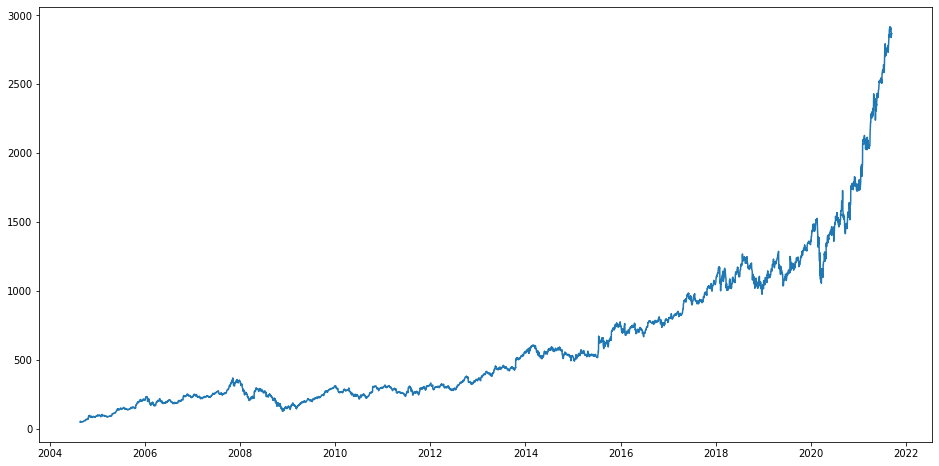

In [29]:
# Check close price history with plot
plt.figure(figsize=(16,8))
plt.plot(data_viz['close'], label='Close Price history')

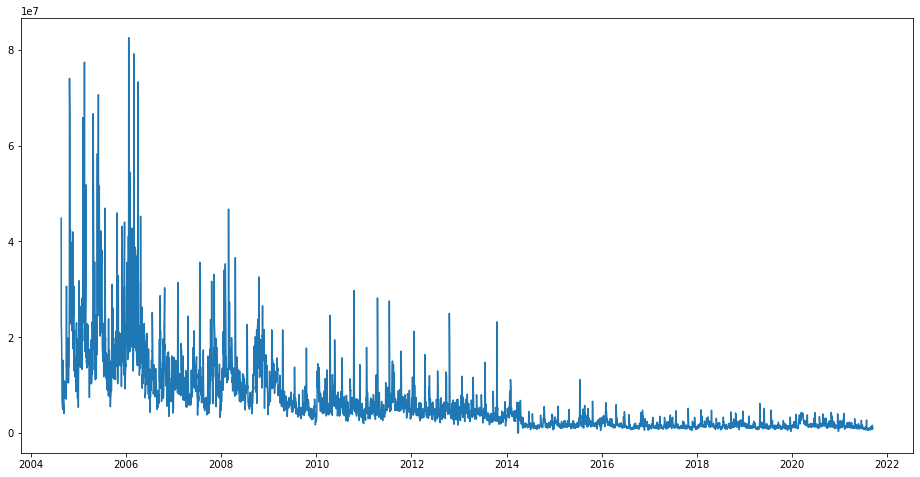

In [30]:
# Check volume history with plot
plt.figure(figsize=(16,8))
plt.plot(data_viz['volume'], label='Volume history')

## Train and Test Model

### Training Model

In [31]:
# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

In [32]:
# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_goog + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_goog))

In [33]:
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

Epoch 1/500
57/57 [==============================] - 24s 130ms/step - loss: 0.0037 - mean_absolute_error: 0.0465 - val_loss: 1.0222e-04 - val_mean_absolute_error: 0.0090

Epoch 00001: val_loss improved from inf to 0.00010, saving model to results/2021-09-15_GOOG-sh-1-sc-1-sbd-0-huber_loss-adam-LSTM-seq-50-step-7-layers-3-units-256.h5
Epoch 2/500
57/57 [==============================] - 3s 60ms/step - loss: 5.5603e-04 - mean_absolute_error: 0.0202 - val_loss: 3.2181e-04 - val_mean_absolute_error: 0.0177

Epoch 00002: val_loss did not improve from 0.00010
Epoch 3/500
57/57 [==============================] - 3s 58ms/step - loss: 4.7860e-04 - mean_absolute_error: 0.0185 - val_loss: 1.0451e-04 - val_mean_absolute_error: 0.0096

Epoch 00003: val_loss did not improve from 0.00010
Epoch 4/500
57/57 [==============================] - 3s 58ms/step - loss: 4.4300e-04 - mean_absolute_error: 0.0182 - val_loss: 1.2813e-04 - val_mean_absolute_error: 0.0114

Epoch 00004: val_loss did not improve from 

### Testing Model

In [34]:
def plot_graph(test_df):
    plt.plot(test_df[f'true_adjclose_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'adjclose_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

In [35]:
def get_final_df(model, data):
    buy_profit  = lambda current, pred_future, true_future: true_future - current if pred_future > current else 0
    sell_profit = lambda current, pred_future, true_future: current - true_future if pred_future < current else 0
    X_test = data["X_test"]
    y_test = data["y_test"]
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    test_df = data["test_df"]
    # add predicted future prices to the dataframe
    test_df[f"adjclose_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_adjclose_{LOOKUP_STEP}"] = y_test
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    final_df = test_df
    # add the buy profit column
    final_df["buy_profit"] = list(map(buy_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    )
    # add the sell profit column
    final_df["sell_profit"] = list(map(sell_profit, 
                                    final_df["adjclose"], 
                                    final_df[f"adjclose_{LOOKUP_STEP}"], 
                                    final_df[f"true_adjclose_{LOOKUP_STEP}"])
                                    )
    return final_df

In [36]:
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["adjclose"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
    return predicted_price

In [37]:
# load optimal model weights from results folder
model_path = os.path.join("results", model_goog) + ".h5"
model.load_weights(model_path)

In [38]:
# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
else:
    mean_absolute_error = mae

In [39]:
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

In [40]:
# predict the future price
future_price = predict(model, data)

In [41]:
# calculate the accuracy by counting the number of positive profits
accuracy_score = (len(final_df[final_df['sell_profit'] > 0]) + len(final_df[final_df['buy_profit'] > 0])) / len(final_df)

In [42]:
# calculating total buy & sell profit
total_buy_profit  = final_df["buy_profit"].sum()
total_sell_profit = final_df["sell_profit"].sum()

In [43]:
# total profit by adding sell & buy together
total_profit = total_buy_profit + total_sell_profit

In [44]:
# dividing total profit by number of testing samples (number of trades)
profit_per_trade = total_profit / len(final_df)

In [45]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")
print(f"{LOSS} loss:", loss)
print("Mean Absolute Error:", mean_absolute_error)
print("Accuracy score:", accuracy_score)
print("Total buy profit:", total_buy_profit)
print("Total sell profit:", total_sell_profit)
print("Total profit:", total_profit)
print("Profit per trade:", profit_per_trade)

Future price after 7 days is 2890.03$
huber_loss loss: 6.141766789369285e-05
Mean Absolute Error: 70.53619010471128
Accuracy score: 0.5777080062794349
Total buy profit: 3041.3683166503915
Total sell profit: 263.1854934692393
Total profit: 3304.5538101196307
Profit per trade: 5.1876825904546795


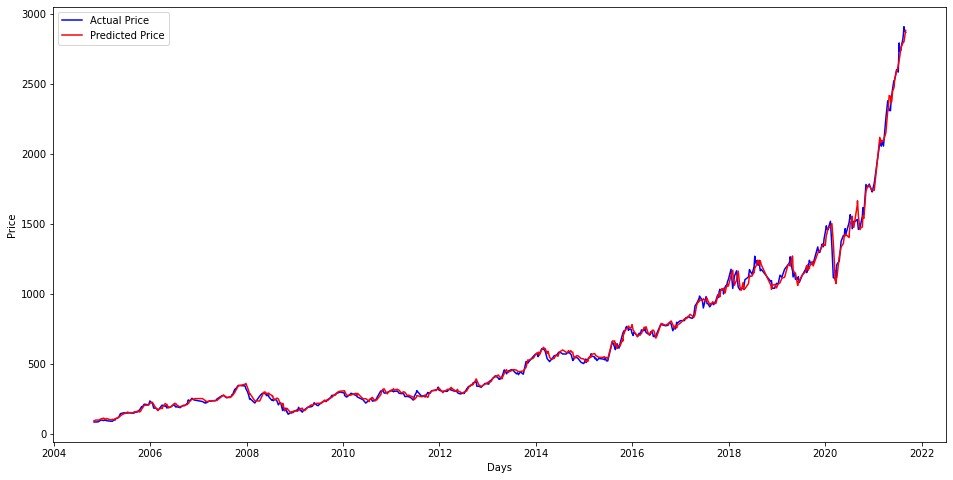

In [46]:
# plot true/pred prices graph
plt.figure(figsize=(16,8))
plot_graph(final_df)

In [47]:
print(final_df.tail(10))
# save the final dataframe to csv-results folder
csv_results_folder = "csv-results"
if not os.path.isdir(csv_results_folder):
    os.mkdir(csv_results_folder)
csv_filename = os.path.join(csv_results_folder, model_goog + ".csv")
final_df.to_csv(csv_filename)

                   open         high  ...  buy_profit  sell_profit
2021-07-09  2578.889893  2596.989990  ...   30.540039     0.000000
2021-07-15  2650.000000  2651.899902  ...  167.559814     0.000000
2021-07-16  2632.820068  2643.659912  ...   99.020020     0.000000
2021-07-28  2771.239990  2793.520020  ...   13.090088     0.000000
2021-07-29  2727.612061  2743.030029  ...   29.229980     0.000000
2021-08-12  2754.260010  2768.360107  ...   54.199951     0.000000
2021-08-16  2760.000000  2779.810059  ...   80.679932     0.000000
2021-08-20  2741.659912  2772.290039  ...  140.500000     0.000000
2021-08-24  2830.870117  2860.149902  ...    0.000000   -36.409912
2021-09-02  2918.989990  2926.500000  ...    0.000000    16.259766

[10 rows x 11 columns]


## Conclusion
* Predicted future price after 1 week is `$`2890
* Model has accuracy of 57.7%
* Profit per trade about `$`5